# method to plot 2 images

In [ ]:
# Plot function to compare two images [original vs. processed]
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
  # Visualize undirstorsion
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
  ax1.set_title(orig_title, fontsize=30)
  ax1.imshow(orig_image)
  ax2.set_title(processed_title, fontsize=30)
  ax2.imshow(processed_image, cmap='gray')
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Import Essential Libraries

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from docopt import docopt
from moviepy.editor import VideoFileClip
import glob
from google.colab.patches import cv2_imshow

# Read a test frame

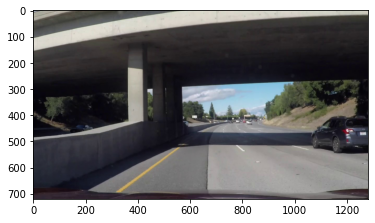

In [ ]:
# the image is now BGR
original_test_BGR = cv2.imread('/content/challenge_video_frame_120.jpg')
original_test_RGB = cv2.cvtColor(original_test_BGR, cv2.COLOR_BGR2RGB)
test_frame_img = mpimg.imread('/content/challenge_video_frame_120.jpg')
plt.imshow(test_frame_img)

# (1) Calibrate the camera and remove the distortion

## Camera Calibration

In [ ]:
def calibrate_camera():
  """ Calibrate the camera using list of calibration images and return the 
      camera matrix and distortion coeff    
   """
  # 9 intersections in x-axis and 6 intersections in y-axis
  nx = 9
  ny = 6
  objpoints = []
  imgpoints = []
  # create matrix with size of all corners with 3 dim
  objp = np.zeros((nx*ny, 3), np.float32)
  objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

  # Make a list of calibration images
  frames = glob.glob('/content/drive/MyDrive/camera_cal/calibration*.jpg')
  # loop through the frames paths
  for frame in frames:
    # read the frame using the given path
    img = mpimg.imread(frame)
    # calibration_img_BGR = cv2.imread(frame)
    # calibration_img_RGB = cv2.cvtColor(calibration_img_BGR, cv2.COLOR_BGR2RGB)
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx, ny))
    if ret:
      imgpoints.append(corners)
      objpoints.append(objp)

  shape = (img.shape[1], img.shape[0])
  ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
  return mtx, dist

camera_Matrix, distortion_Coeff = calibrate_camera() 

## Undistortion

In [ ]:
def undistort(test_frame):
  """ 
    # Method number 1 in pipeline of the main function ...
    this method remove the distortion from the image
  """
  return cv2.undistort(test_frame, camera_Matrix, distortion_Coeff, None, camera_Matrix)

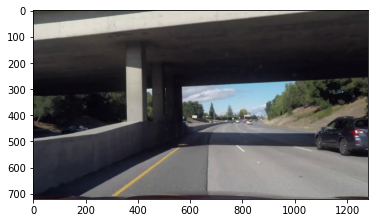

In [ ]:
undistorted_img = undistort(test_frame_img)
plt.imshow(undistorted_img)

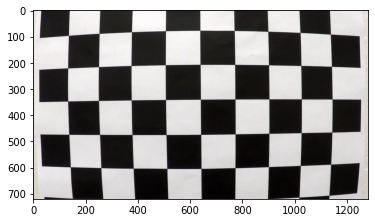

In [ ]:
calibrated_BGR = cv2.imread('/content/drive/MyDrive/camera_cal/calibration01.jpg')
calibrated_RGB = cv2.cvtColor(calibrated_BGR, cv2.COLOR_BGR2RGB)
undistorted_calibrated = undistort(calibrated_RGB)
plt.imshow(calibrated_RGB)

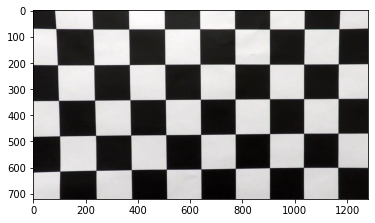

In [ ]:
plt.imshow(undistorted_calibrated)

# (2) Finding Top (Eye-bird) view from Front-view

In [ ]:
src = np.float32([(550, 460),     # top-left
                  (150, 720),     # bottom-left
                  (1200, 720),    # bottom-right
                  (770, 460)])    # top-right
dst = np.float32([(100, 0),
                  (100, 720),
                  (1100, 720),
                  (1100, 0)])

In [ ]:
def get_transform_matrix(src, dst):
  """ get the transform matrix from src and dst dimensions """
  M = cv2.getPerspectiveTransform(src, dst)
  return M

def get_inverse_transform_matrix(src, dst):
  """ get the inverse transform matrix from src and dst dimensions """
  M_inv = cv2.getPerspectiveTransform(dst, src)
  return M_inv

In [ ]:
# get the transform and inverse transform matrix
transform_matrix = get_transform_matrix(src, dst)
inverse_transform_matrix = get_inverse_transform_matrix(src, dst)

In [ ]:
def get_eye_bird_view(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
  """ 
  Take a front view image and transform to top view
  Parameters:
      img (np.array): A front view image
      img_size (tuple): Size of the image (width, height)
      flags : flag to use in cv2.warpPerspective()

  Returns:
      Image (np.array): Top view image
  """
  return cv2.warpPerspective(img, transform_matrix, img_size, flags=flags)

In [ ]:
def get_front_view(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
  """ Take a top view image and transform it to front view

  Parameters:
      img (np.array): A top view image
      img_size (tuple): Size of the image (width, height)
      flags (int): flag to use in cv2.warpPerspective()

  Returns:
      Image (np.array): Front view image
  """
  return cv2.warpPerspective(img, inverse_transform_matrix, img_size, flags=flags)


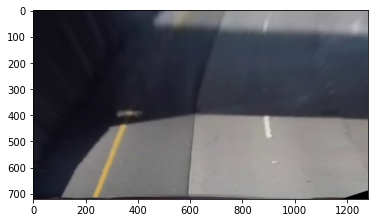

In [ ]:
eye_bird_undistorted_img = get_eye_bird_view(undistorted_img)
plt.imshow(eye_bird_undistorted_img)

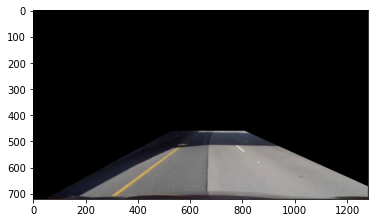

In [ ]:
x = get_front_view(eye_bird_undistorted_img)
plt.imshow(x)

# (3) Thresholding

In [ ]:
def threshold_rel(img, lo, hi):
  vmin = np.min(img)
  # print("vmin = ", vmin)
  vmax = np.max(img)
  # print("vmax = ", vmax)
  vlo = vmin + (vmax - vmin) * lo
  # print("vlo = ", vlo)
  vhi = vmin + (vmax - vmin) * hi
  # print("vhi = ", vhi)
  # print(np.uint8((img >= vlo) & (img <= vhi)) * 255)
  return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
  # print(np.uint8((img >= lo) & (img <= hi)) * 255)
  return np.uint8((img >= lo) & (img <= hi)) * 255

In [ ]:
def thresholding(img):
  """ Take an image and extract all relavant pixels.

  Parameters:
      img (np.array): Input image

  Returns:
      binary (np.array): A binary image represent all positions of relavant pixels.
  """
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  h_channel = hls[:,:,0]
  l_channel = hls[:,:,1]
  s_channel = hls[:,:,2]
  v_channel = hsv[:,:,2]
  # we choosed the L-channel to detect the right lane because the right lane is almost white
  # so we put the min threshold to 80% and max threshold to be 100%
  right_lane = threshold_rel(l_channel, 0.8, 1.0)
  right_lane[:,:750] = 0
  # print("right_lane", right_lane)
  # choose the range from 30*(2/3) = 20 and 60*(2/3) = 40 but we will take the range from 20 to 30 only because the dark yellow is not in our case
  left_lane = threshold_abs(h_channel, 20, 30)
  # the value of the color is from 70 % to 100 % in intensity
  left_lane &= threshold_rel(v_channel, 0.7, 1.0)
  left_lane[:,550:] = 0
  img2 = left_lane | right_lane
  return img2

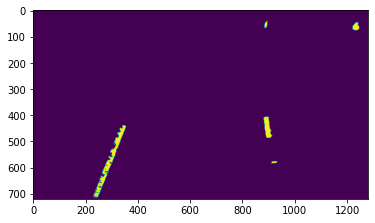

In [ ]:
thresholded_img = thresholding(eye_bird_undistorted_img)
plt.imshow(thresholded_img)

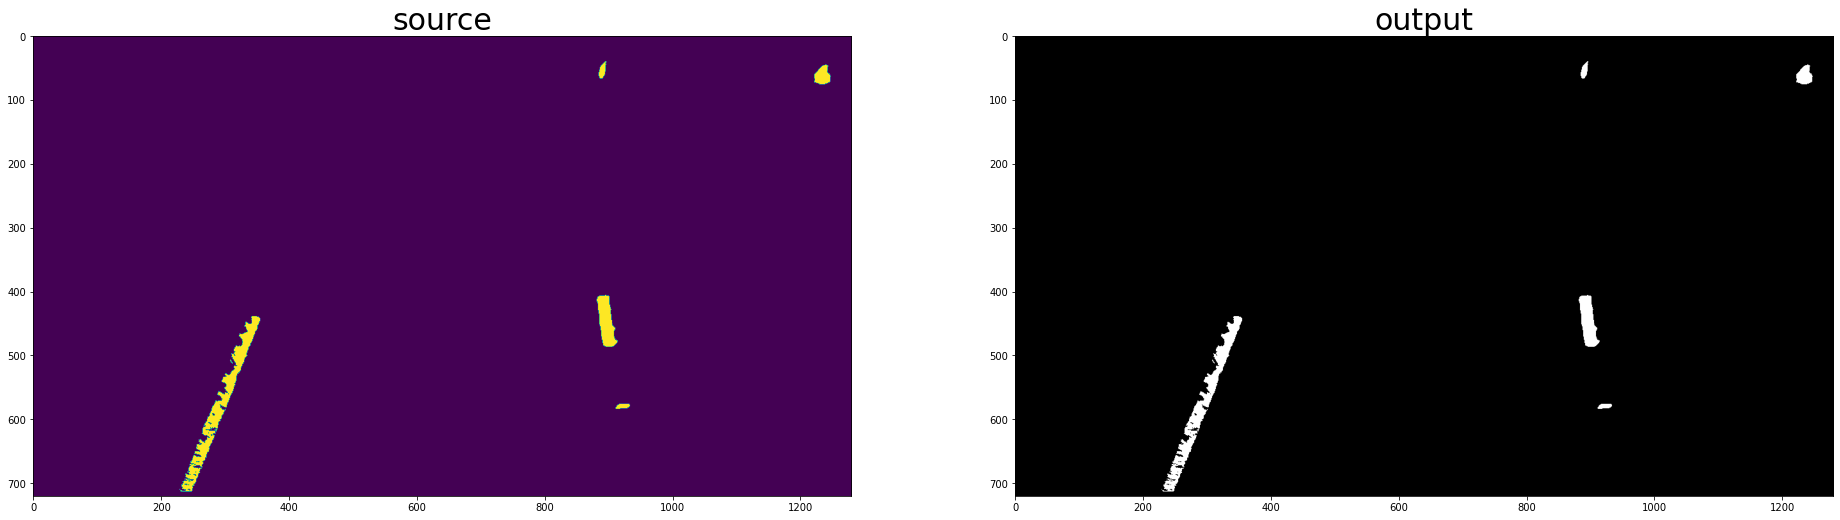

In [ ]:
# Plot function to compare two images [original vs. processed]
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
  # Visualize undirstorsion
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
  ax1.set_title(orig_title, fontsize=30)
  ax1.imshow(orig_image)
  ax2.set_title(processed_title, fontsize=30)
  ax2.imshow(processed_image, cmap='gray')
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt_images(thresholded_img, "source", thresholded_img, "output")

# (4) Lane Lines Detection

* we will assume that we will have 9 windows per lane 
* the width of the window = 2 * margin 
* margin = 100
* the minimum number of pixels to recenter a single window is minpix , and minpix = 50

In [ ]:
# def forward(img):
#   extract_features(img)
#   return fit_poly(img)


### get_histogram ▶
 this function receives an image and retuns histogram representation

In [ ]:
# def get_histogram(img):
#   """ function that returns a histogram for a passed image """ 
#   # take the bottom half of the image by taking all rows starting 
#   # from the middle of the image to the bottom of the image
#   # and take all the width
#   bottom_half = img[img.shape[0]//2:,:]
#   # return the sum of all the rows starting from the bottom half of the image
#   return np.sum(bottom_half, axis=0)

### Extract_Features() ▶

#### Required Variables

In [ ]:
# nwindows = 9
# margin = 100
# minpix = 50
# binary = None
# left_fit = None
# right_fit = None
# dir = []
# nonzero = None
# nonzerox = None
# nonzeroy = None
# clear_visibility = True
# window_height = 0
# left_curve_img = mpimg.imread('left_turn.png') 
# right_curve_img = mpimg.imread('right_turn.png')
# keep_straight_img = mpimg.imread('straight.png')
# left_curve_img = cv2.normalize(src=left_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# right_curve_img = cv2.normalize(src=right_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# keep_straight_img = cv2.normalize(src=keep_straight_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


### Extract more features

In [ ]:
# def extract_features(img):
#   global nonzero
#   global nonzerox
#   global nonzeroy
#   global window_height
#   window_height = np.int(thresholded_img.shape[0]//nwindows)
#   # Identify the x and y positions of all nonzero pixel in the image
#   nonzero = thresholded_img.nonzero()
#   # returns the nonzero from width (cols)
#   nonzerox = np.array(nonzero[1])
#   # returns the nonzero from height (rows)
#   nonzeroy = np.array(nonzero[0])

we have 9 windows per lane, and we have the height of the lane which is equale the height of the eye-bird image .. so we can calculate the height of a single window

### lets test the histogram of our eye-bird thresholded image

In [ ]:
# histo = get_histogram(thresholded_img)
# plt.plot(histo)
# plt.xlim(0, 1280)

### pixels_in_window ▶
 returns all pixels that in a specific window

In [ ]:
# def pixels_in_window(center, margin, height):
#   global nonzerox
#   global nonzeroy
#   """ Return all pixel that in a specific window

#   Parameters:
#       center (tuple): coordinate of the center of the window
#       margin (int): half width of the window
#       height (int): height of the window

#   Returns:
#       pixelx (np.array): x coordinates of pixels that lie inside the window
#       pixely (np.array): y coordinates of pixels that lie inside the window
#   """
#   topleft = (center[0]-margin, center[1]-height//2)
#   bottomright = (center[0]+margin, center[1]+height//2)

#   condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
#   condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
#   return nonzerox[condx&condy], nonzeroy[condx&condy]

<!-- ![pixels_in_window](https://drive.google.com/uc?export=view&id=1HBFqpTN3DAcMFS9NQwOM3kBTAqPpPqcr) -->

### find_lane_pixels(img) ▶
find all pixels of the lane by getting the all non-zero pixels on each window and add them all together, same for the right lane 

In [ ]:
# def find_lane_pixels(img):
#   """
#   this function find the x,y coordinates of all pixels in left lane
#   and also find the x,y coordinates of all pixels in right lane
#   returns:
#     > leftx
#     > rightx
#     > lefty
#     >righty
#   """
#   global window_height
#   global nwindows
#   global margin
#   global minpix

#   assert(len(img.shape) == 2)
#   # Create an output image to draw on and visualize the result
#   out_img = np.dstack((img, img, img))

#   # get the histogram of the image
#   histogram = get_histogram(img)
#   # get the mid point of this histogram
#   midpoint = histogram.shape[0]//2
#   # divide the histogram to 2 parts 
#   # -> getting the max index of max point from starting point of the histogram to the midpoint
#   leftx_base = np.argmax(histogram[:midpoint])
#   # -> the max index of max point from midpoint to the end of histogram
#   rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#   # lets now store the left_base and right_base into new variables to update them without any errors
#   leftx_current = leftx_base
#   rightx_current = rightx_base

#   # initially we are above the height of the image by 0.5 window height  = 370 "350 + 20" window_height = 40
#   y_current = img.shape[0] + window_height//2

#   # Create empty lists to reveice left and right lane pixel
#   leftx, lefty, rightx, righty = [], [], [], []

#   # Step through the windows one by one
#   for _ in range(nwindows):
#     # center of the current window (from top to bottom)
#     y_current -= window_height
#     # we are operating the left and right window in parallel,
#     # we are starting from the center of the first window of left and right lanes starting from top to bottm
#     center_left = (leftx_current, y_current)
#     center_right = (rightx_current, y_current)

#     good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height)
#     good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height)

#     # Append these indices to the lists
#     leftx.extend(good_left_x)
#     lefty.extend(good_left_y)
#     rightx.extend(good_right_x)
#     righty.extend(good_right_y)

#     if len(good_left_x) > minpix:
#         leftx_current = np.int32(np.mean(good_left_x))
#     if len(good_right_x) > minpix:
#         rightx_current = np.int32(np.mean(good_right_x))

#   return leftx, lefty, rightx, righty, out_img



### we won't use the Hough transform to detect the lines because Hough transform works well with straight lines but we are dealing with curved lines, so we will use polyfit technique which fits the curved lines by mapping the given points with a polynomial from given degree "we will set the degree to be = 2" So, the poly will be `a X^2 + b X + c `


### fit_poly(img) ▶
 using fitpoly technique instead of hough transform as we mentioned

In [ ]:
# def fit_poly(img):
#   """Find the lane line from an image and draw it.

#   Parameters:
#       img (np.array): a binary warped image

#   Returns:
#       out_img (np.array): a RGB image that have lane line drawn on that.
#   """
#   global left_fit
#   global right_fit

#   # we have all pixels in each window in left and right lanes
#   leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

#   if len(lefty) > 1500:
#     left_fit = np.polyfit(lefty, leftx, 2) # 2nd degree polynomial 
#     # print(left_fit)
#   if len(righty) > 1500:
#     right_fit = np.polyfit(righty, rightx, 2)

#   # Generate x and y values for plotting
#   maxy = img.shape[0] - 1
#   miny = img.shape[0] // 3
#   if len(lefty):
#     maxy = max(maxy, np.max(lefty))
#     miny = min(miny, np.min(lefty))

#   if len(righty):
#     maxy = max(maxy, np.max(righty))
#     miny = min(miny, np.min(righty))

#   ploty = np.linspace(miny, maxy, img.shape[0])

#   left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#   right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#   # Visualization
#   for i, y in enumerate(ploty):
#     l = int(left_fitx[i])
#     r = int(right_fitx[i])
#     y = int(y)
#     cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

#   lR, rR, pos = measure_curvature()
#   return out_img

### function to measure the curvature ▶

In [ ]:
# def measure_curvature():
#   global left_fit
#   global right_fit

#   ym = 30/720
#   xm = 3.7/700

#   left_fit = left_fit.copy()
#   right_fit = right_fit.copy()

#   y_eval = 700 * ym
#   # Compute R_curve (radius of curvature)
#   left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
#   right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

#   xl = np.dot(left_fit, [700**2, 700, 1])
#   xr = np.dot(right_fit, [700**2, 700, 1])
#   pos = (1280//2 - (xl+xr)//2)*xm
#   return left_curveR, right_curveR, pos 


### test the fit poly which detects the lines and fill the space

In [ ]:
# out_img =  fit_poly(thresholded_img)
# plt.imshow(out_img)

### now get the front view of the processed image

In [ ]:
# out_img = get_front_view(out_img)
# plt.imshow(out_img)

### finally combine the images together to find the result frame before saving to the video

In [ ]:
# out_img = cv2.addWeighted(original_test_RGB, 1, out_img, 0.6, 0)
# plt.imshow(out_img)

### plotting function ▶

In [ ]:
# def plot(out_img):
#   global dir
#   global left_fit
#   global right_fit
#   global left_curve_img
#   global right_curve_img
#   global keep_straight_img
#   global left_curve_img
#   global right_curve_img
#   global keep_straight_img

#   np.set_printoptions(precision=6, suppress=True)
  
#   lR, rR, pos = measure_curvature()

#   value = None
#   if abs(left_fit[0]) > abs(right_fit[0]):
#     value = left_fit[0]
#   else:
#     value = right_fit[0]

#   if abs(value) <= 0.00015:
#     dir.append('F')
#   elif value < 0:
#     dir.append('L')
#   else:
#     dir.append('R')
  
#   if len(dir) > 10:
#     dir.pop(0)

#   W = 400
#   H = 500
#   widget = np.copy(out_img[:H, :W])
#   widget //= 2
#   widget[0,:] = [0, 0, 255]
#   widget[-1,:] = [0, 0, 255]
#   widget[:,0] = [0, 0, 255]
#   widget[:,-1] = [0, 0, 255]
#   out_img[:H, :W] = widget

#   direction = max(set(dir), key = dir.count)
#   msg = "Keep Straight Ahead"
#   curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
#   if direction == 'L':
#     y, x = left_curve_img[:,:,3].nonzero()
#     out_img[y, x-100+W//2] = left_curve_img[y, x, :3]
#     msg = "Left Curve Ahead"
#   if direction == 'R':
#     y, x = right_curve_img[:,:,3].nonzero()
#     out_img[y, x-100+W//2] = right_curve_img[y, x, :3]
#     msg = "Right Curve Ahead"
#   if direction == 'F':
#     y, x = keep_straight_img[:,:,3].nonzero()
#     out_img[y, x-100+W//2] = keep_straight_img[y, x, :3]

#   cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
#   if direction in 'LR':
#     cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

#   cv2.putText(
#       out_img,
#       "Good Lane Keeping",
#       org=(10, 400),
#       fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#       fontScale=1.2,
#       color=(0, 255, 0),
#       thickness=2)

#   cv2.putText(
#       out_img,
#       "Vehicle is {:.2f} m away from center".format(pos),
#       org=(10, 450),
#       fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#       fontScale=0.66,
#       color=(255, 255, 255),
#       thickness=2)

#   return out_img

In [ ]:
# plotted = plot(out_img)
# plt.imshow(plotted)

# CLass Based 

In [ ]:
def hist(img):
  """
      inputs: image
      outputs: historgram of the image
  """
  # take the bottom half of the image by taking all rows starting from the middle of the image to the bottom of the image
  # and take all the width
  bottom_half = img[img.shape[0]//2:,:]
  # return the sum of all the rows starting from the bottom half of the image
  return np.sum(bottom_half, axis=0)

class LaneLines:

    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []
        # optional ................................
        self.left_curve_img = mpimg.imread('left_turn.png') 
        self.right_curve_img = mpimg.imread('right_turn.png')
        self.keep_straight_img = mpimg.imread('straight.png')
        self.left_curve_img = cv2.normalize(src=self.left_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.right_curve_img = cv2.normalize(src=self.right_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.keep_straight_img = cv2.normalize(src=self.keep_straight_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 100
        # Mininum number of pixels found to recenter window
        self.minpix = 50
#! DONE
    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.fit_poly(img)
#!DONE
    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of windows -> based on nwindows and image shape
        self.window_height = np.int(img.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        # returns the nonzero from width (cols)
        self.nonzerox = np.array(self.nonzero[1])
        # returns the nonzero from height (rows)
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        """Find lane pixels from a binary warped image.

        Parameters:
            img (np.array): A binary warped image

        Returns:
            leftx (np.array): x coordinates of left lane pixels
            lefty (np.array): y coordinates of left lane pixels
            rightx (np.array): x coordinates of right lane pixels
            righty (np.array): y coordinates of right lane pixels
            out_img (np.array): A RGB image that use to display result later on.
        """
        assert(len(img.shape) == 2)

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img, img, img))

        histogram = hist(img)
        midpoint = histogram.shape[0]//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        # initially we are above the height of the image by 0.5 window height  = 370 "350 + 20" window_height = 40
        y_current = img.shape[0] + self.window_height//2

        # Create empty lists to reveice left and right lane pixel
        leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
        for _ in range(self.nwindows):
            # center of the current window (from top to bottom)
            y_current -= self.window_height
            # we are operating the left and right window in parallel,
            # we are starting from the center of the first window of left and right lanes starting from top to bottm
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            # Append these indices to the lists
            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        """Find the lane line from an image and draw it.

        Parameters:
            img (np.array): a binary warped image

        Returns:
            out_img (np.array): a RGB image that have lane line drawn on that.
        """
        # we have all pixels in each window in left and right lanes
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2) # 2nd degree polynomial 
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])

        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Visualization
        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

        lR, rR, pos = self.measure_curvature()

        return out_img

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)
        
        lR, rR, pos = self.measure_curvature()

        value = None
        if abs(self.left_fit[0]) > abs(self.right_fit[0]):
            value = self.left_fit[0]
        else:
            value = self.right_fit[0]

        if abs(value) <= 0.00015:
            self.dir.append('F')
        elif value < 0:
            self.dir.append('L')
        else:
            self.dir.append('R')
        
        if len(self.dir) > 10:
            self.dir.pop(0)

        W = 400
        H = 500
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0,:] = [0, 0, 255]
        widget[-1,:] = [0, 0, 255]
        widget[:,0] = [0, 0, 255]
        widget[:,-1] = [0, 0, 255]
        out_img[:H, :W] = widget

        direction = max(set(self.dir), key = self.dir.count)
        msg = "Keep Straight Ahead"
        curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
        if direction == 'L':
            y, x = self.left_curve_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.left_curve_img[y, x, :3]
            msg = "Left Curve Ahead"
        if direction == 'R':
            y, x = self.right_curve_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.right_curve_img[y, x, :3]
            msg = "Right Curve Ahead"
        if direction == 'F':
            y, x = self.keep_straight_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.keep_straight_img[y, x, :3]

        cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        if direction in 'LR':
            cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        cv2.putText(
            out_img,
            "Good Lane Keeping",
            org=(10, 400),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.2,
            color=(0, 255, 0),
            thickness=2)

        cv2.putText(
            out_img,
            "Vehicle is {:.2f} m away from center".format(pos),
            org=(10, 450),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.66,
            color=(255, 255, 255),
            thickness=2)

        return out_img

    def measure_curvature(self):
        ym = 30/720
        xm = 3.7/700

        left_fit = self.left_fit.copy()
        right_fit = self.right_fit.copy()
        y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        xl = np.dot(self.left_fit, [700**2, 700, 1])
        xr = np.dot(self.right_fit, [700**2, 700, 1])
        pos = (1280//2 - (xl+xr)//2)*xm
        return left_curveR, right_curveR, pos 


# (5) Pipeline 

In [ ]:
from docopt import docopt
from moviepy.editor import VideoFileClip
from IPython.core.display import Video

In [ ]:
lanelines = LaneLines()

In [ ]:
def pipeline(input_frame):
  out_img = np.copy(input_frame)
  input_frame = undistort(input_frame)
  input_frame = get_eye_bird_view(input_frame)
  input_frame = thresholding(input_frame)
  input_frame = lanelines.forward(input_frame)
  input_frame = get_front_view(input_frame)
  out_img = cv2.addWeighted(out_img, 1, input_frame, 0.6, 0)
  out_img = lanelines.plot(out_img)
  return out_img  

### Lets test our pipeline on a single frame 

In [ ]:
# result_testing = pipeline(original_test_RGB)
# plt.imshow(result_testing)

In [ ]:
def process_video(input_path, output_path):
    clip = VideoFileClip(input_path)
    out_clip = clip.fl_image(pipeline)
    out_clip.write_videofile(output_path, audio=False)

### lets now test the pipeline on a video

In [ ]:
process_video('challenge_video.mp4' , 'output_v5.mp4')

[MoviePy] >>>> Building video output_v5.mp4
[MoviePy] Writing video output_v5.mp4


100%|██████████| 485/485 [01:15<00:00,  6.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v5.mp4 

